# Applying a cnn to classify amino acids bassed on their atom types and heavy atoms

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy
from sklearn.metrics import accuracy_score
from src.dataset import AminoAcidDataset
from src.model import AminoAcidCNN
from src.train import train_model, evaluate_model

## 1. Loading the Datset using a custom Data class


```python
class AminoAcidDataset(torch.utils.data.Dataset):
    '''AminoAcidDataset class
    
    This class loads the amino acid dataset from a PDB file and stores the coordinates and 
    elements of each atom in the structure.

    Args:
        pdb_file (str): The path to the PDB file.
        padding (bool): If True, the coordinates and elements will be padded 
                        to have the same length for all residues.
    '''

    def __init__(self, pdb_file: str, padding: bool=False) -> None:
        ...
```

In [2]:
# Create an instance of the dataset
dataset = AminoAcidDataset('data/amino_acids_2_0A_augmented.pdb', padding=True)
print(f"Number of samples: {len(dataset)}")

# Split the dataset into training and testing sets using an 80/20 split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

## 2. Initialize model and initialize

In [3]:
N, M = dataset.input_shape
model = AminoAcidCNN(input_channels=1, # Since we added an extra dimension for batch and channel
                     input_height=N, # Number of atoms
                     input_width=3+M) # 3 coordinates + 4 element types

## 3. Train the model

The training loop of the model comprises several important steps. 
A simple representation of the training loop looks like this:

```python
def train_model(...) -> dict:
    """Train a PyTorch model."""
    
    # Iiterate the number of epochs 
    for epoch in range(n_epochs):
        # Iterate over all the data in the training set
        for coordinates, elements, residue in data_loader:
            input_data = torch.cat((coordinates, elements), dim=2)
            input_data = input_data.unsqueeze(1)
            # 1. Calculate the results = forward passs
            output = model(input_data)
            # 2. Calculate the loss (using our loss function)
            target = torch.argmax(residue, dim=1)
            loss = criterion(output, target) 
            # 3. Optimize the model = backward pass 
            optimizer.zero_grad()  # Clear the gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters
            ...
```

Tuning the training process is central to the quality of the model

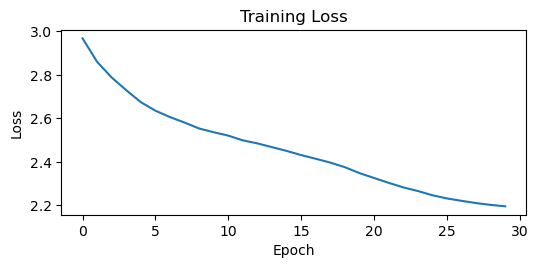

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the models
training_dict = train_model(model=model, criterion=criterion, optimizer=optimizer, data_loader=train_dataloader, n_epochs=30,coord_only=False)

# Plot the training loss
plt.figure(figsize=(6, 2.4))
plt.plot(x=range(1, len(training_dict['total_loss'])+1), y=training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlim(0, len(training_dict['total_loss'])+1)
plt.show()

## 4. Evaluate the model